In [1]:
!pip install scikit-learn pandas matplotlib joblib

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib

In [24]:
import pandas as pd
import joblib

# Load the trained model
model = joblib.load('./best_model.joblib')

# Example: Create new applicant data (with same columns as training data)
new_data = {
    "Gender": ["Male"],
    "Married": ["Yes"],
    "Dependents": ["0"],
    "Education": ["Graduate"],
    "Self_Employed": ["No"],
    "ApplicantIncome": [5000],
    "CoapplicantIncome": [2000],
    "LoanAmount": [150],
    "Loan_Amount_Term": [360],
    "Credit_History": [1.0],
    "Property_Area": ["Urban"]
}

# Convert to DataFrame
new_X_dataframe = pd.DataFrame(new_data)

# Predict
preds = model.predict(new_X_dataframe)
print("Loan Approval Prediction:", "Approved" if preds[0] == "Y" else "Rejected")


Loan Approval Prediction: Rejected


In [4]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("loan_data.csv")

Saving loan_data.csv to loan_data (1).csv


In [5]:
from sklearn.datasets import make_classification
X_syn, y_syn = make_classification(n_samples=2000, n_features=10, n_informative=6,
                                   n_redundant=2, n_classes=2, random_state=42)

In [6]:
df = pd.DataFrame(X_syn, columns=[f"num_feat_{i}" for i in range(10)])
df["ApplicantIncome"] = (np.abs(df["num_feat_0"]) * 3000 + 2000).astype(int)
df["CoapplicantIncome"] = (np.abs(df["num_feat_1"]) * 1500).astype(int)
df["LoanAmount"] = (np.abs(df["num_feat_2"]) * 200).astype(int) + 50
df["Loan_Amount_Term"] = np.random.choice([360.0, 180.0, 120.0], size=len(df), p=[0.7,0.2,0.1])
df["Credit_History"] = np.random.choice([1.0, 0.0], size=len(df), p=[0.8, 0.2])
df["Gender"] = np.random.choice(["Male","Female"], size=len(df), p=[0.7,0.3])
df["Married"] = np.random.choice(["Yes","No"], size=len(df), p=[0.6,0.4])
df["Education"] = np.random.choice(["Graduate","Not Graduate"], size=len(df), p=[0.8,0.2])
df["Property_Area"] = np.random.choice(["Urban","Rural","Semiurban"], size=len(df), p=[0.4,0.3,0.3])
df["Loan_Status"] = y_syn

cols = ["Gender","Married","Education","ApplicantIncome","CoapplicantIncome",
        "LoanAmount","Loan_Amount_Term","Credit_History","Property_Area","Loan_Status"]
df = df[cols]

print("✅ Dataset Loaded Successfully!")
print(df.head())


✅ Dataset Loaded Successfully!
   Gender Married     Education  ApplicantIncome  CoapplicantIncome  \
0    Male     Yes  Not Graduate            11691               1567   
1    Male     Yes  Not Graduate             4908                 41   
2    Male     Yes      Graduate             2700               2987   
3  Female      No  Not Graduate             7240               1508   
4    Male     Yes  Not Graduate             5011               2297   

   LoanAmount  Loan_Amount_Term  Credit_History Property_Area  Loan_Status  
0         189             360.0             1.0         Rural            1  
1         148             120.0             1.0         Rural            0  
2         141             360.0             0.0         Urban            0  
3         305             360.0             1.0         Urban            0  
4         408             360.0             1.0         Urban            1  


In [7]:
X = df.drop(columns=["Loan_Status"])
y = df["Loan_Status"]

In [8]:
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Numerical Columns: {numerical_cols}")
print(f"Categorical Columns: {categorical_cols}")


Numerical Columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical Columns: ['Gender', 'Married', 'Education', 'Property_Area']


In [10]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, numerical_cols),
    ("cat", cat_transformer, categorical_cols)
])

In [12]:
pipe_log = Pipeline(steps=[("preprocessor", preprocessor),
                           ("clf", LogisticRegression(max_iter=1000, random_state=42))])

pipe_tree = Pipeline(steps=[("preprocessor", preprocessor),
                            ("clf", DecisionTreeClassifier(random_state=42))])


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [14]:
pipe_log.fit(X_train, y_train)
pipe_tree.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Married',
                                                   'Education',
                                                   'Property_Area'])])),
                ('clf', DecisionTreeClassifier(random_state=42))])

In [18]:
y_pred_log = pipe_log.predict(X_test)
y_pred_tree = pipe_tree.predict(X_test)

acc_log = accuracy_score(y_test, y_pred_log)
acc_tree = accuracy_score(y_test, y_pred_tree)

print("\n Model Performance:")
print(f"Logistic Regression Accuracy: {acc_log:.4f}")
print(f"Decision Tree Accuracy:       {acc_tree:.4f}")



 Model Performance:
Logistic Regression Accuracy: 0.5300
Decision Tree Accuracy:       0.5275


In [17]:
if acc_log >= acc_tree:
    best_model = pipe_log
    best_name = "Logistic Regression"
else:
    best_model = pipe_tree
    best_name = "Decision Tree"

print(f"\n Best Model Selected: {best_name}")


 Best Model Selected: Logistic Regression


In [19]:
best_model.fit(X, y)
print("Model retrained on full dataset for production use.")

Model retrained on full dataset for production use.


In [20]:
joblib.dump(best_model, "best_model.joblib")
print(" Model saved as best_model.joblib")

 Model saved as best_model.joblib


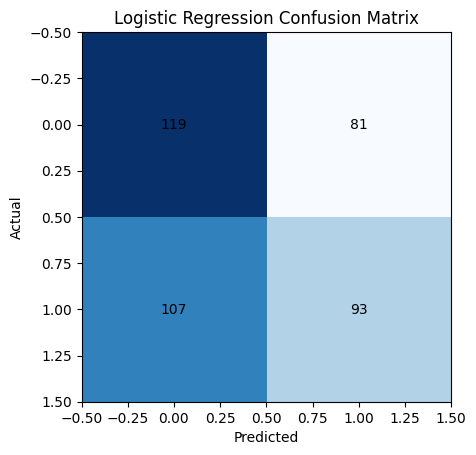

In [21]:
cm = confusion_matrix(y_test, y_pred_log if best_name == "Logistic Regression" else y_pred_tree)
plt.imshow(cm, cmap="Blues")
plt.title(f"{best_name} Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center', color='black')
plt.show()


In [22]:
model = joblib.load("best_model.joblib")
sample = X.sample(5)
print(model.predict(sample))

[0 1 0 1 1]
